<a href="https://colab.research.google.com/github/acardoco/hackaton_nuwe_v3/blob/main/Grupo1DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   Hack that startup 3
*   Team: Grupo1
*   Autores:
*   Andrés Cardoso
*   Raúl Hernáez







In [ ]:
from google.colab import files 
  
  
uploaded = files.upload()

Saving pha_asteroids.csv to pha_asteroids.csv


In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import io
  
df = pd.read_csv(io.BytesIO(uploaded['pha_asteroids.csv'])) 
print(df.columns)
df.head()

Index(['spkid', 'full_name', 'a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y',
       'data_arc', 'condition_code', 'n_obs_used', 'n_del_obs_used',
       'n_dop_obs_used', 'H', 'diameter', 'extent', 'albedo', 'rot_per', 'GM',
       'BV', 'UB', 'IR', 'pha'],
      dtype='object')


,spkid,full_name,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,n_del_obs_used,n_dop_obs_used,H,diameter,extent,albedo,rot_per,GM,BV,UB,IR,pha
0,2000433,433 Eros (A898 PA),1.458167,0.222994,10.830513,304.299134,178.868934,1.133005,1.783330,1.760837,46330.0,0.0,8767,4.0,2.0,10.42,16.840,34.4x11.2x11.2,0.250,5.270,0.000446,0.921,0.531,NaN,N
1,2000719,719 Albert (A911 TB),2.638378,0.546721,11.570400,183.858330,156.191216,1.195922,4.080833,4.285620,40008.0,0.0,1890,NaN,NaN,15.51,NaN,NaN,NaN,5.801,NaN,NaN,NaN,NaN,N
2,2000887,887 Alinda (A918 AA),2.473534,0.570422,9.393849,110.433729,350.512509,1.062575,3.884493,3.890317,37722.0,0.0,2510,NaN,NaN,13.84,4.200,NaN,0.310,28.410,NaN,0.832,0.436,NaN,N
3,2001036,1036 Ganymed (A924 UB),2.665194,0.533095,26.676143,215.544210,132.378538,1.244392,4.085995,4.351123,35257.0,0.0,7044,0.0,1.0,9.25,37.675,NaN,0.238,10.297,NaN,0.842,0.417,NaN,N
4,2001221,1221 Amor (1932 EA1),1.919166,0.435488,11.880444,171.316487,26.677583,1.083392,2.754939,2.658746,32328.0,0.0,552,NaN,NaN,17.39,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


Steps:

1. Analizar el conjunto de datos
2. Normalizar datos y aplicar filtros que hagan falta
3. Dividir en entrenamiento/testeo
4. Probar Algoritmos, implementar grid search para F1-Score 
5. Ensemble y resultado final

# 1. Analizar el conjunto de datos

In [ ]:
df.isnull().values.any()

True

In [ ]:
df['pha'].value_counts(normalize=True)

N    0.916383
Y    0.083617
Name: pha, dtype: float64

**Label encoder de la variable target**

In [ ]:
# convierto en numérico la variable de pha para que entre en la correlacion
df = df[df['pha'].notna()]
label_encoder = LabelEncoder()
df['pha'] = df['pha'].astype(str)
df['pha'] = label_encoder.fit_transform(df.pha)
df.pha.astype(str)

0        0
1        0
2        0
3        0
4        0
        ..
25889    0
25890    0
25891    0
25892    0
25893    1
Name: pha, Length: 25892, dtype: object

**Correlación**

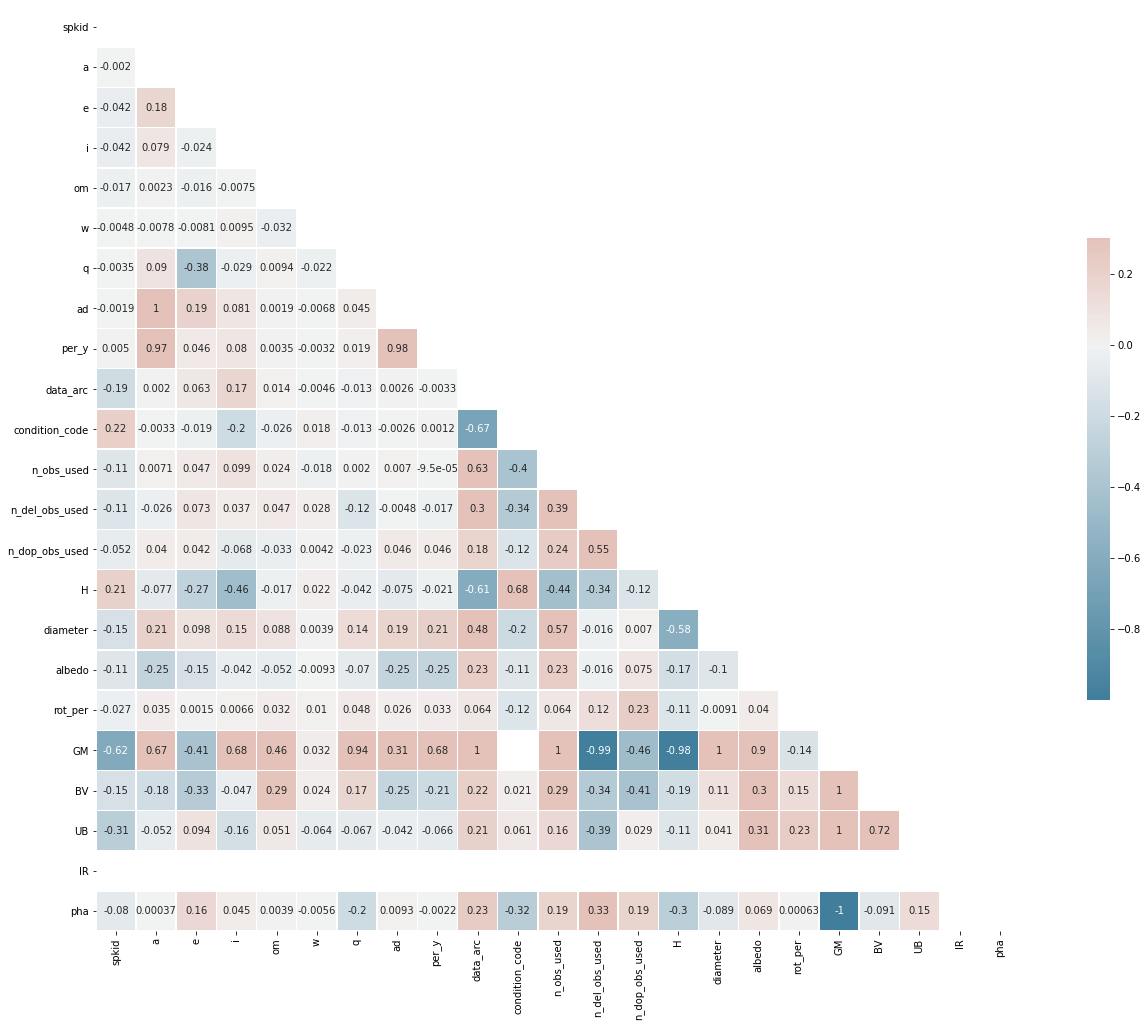

In [ ]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(24, 17))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# 2. Normalizar datos y aplicar filtros que hagan falta

**NaNs**

In [ ]:
print(df.shape)
df.isnull().sum()

(25892, 25)


spkid                 0
full_name             0
a                     0
e                     0
i                     0
om                    0
w                     0
q                     0
ad                    0
per_y                 0
data_arc            226
condition_code        1
n_obs_used            0
n_del_obs_used    24967
n_dop_obs_used    24967
H                     7
diameter          24641
extent            25883
albedo            24686
rot_per           24074
GM                25888
BV                25854
UB                25854
IR                25891
pha                   0
dtype: int64

**Elimino columnas por el nombre (e.g. id) o porque tienen alta correlación con otra**

In [ ]:
df = df[df['H'].notna()]

In [ ]:
# primero, columnas identificador fuera
df = df.drop(columns=['full_name'])
# columnas donde que son un alto % nulos 'n_del_obs_used', 'n_dop_obs_used',  'GM', 'BV', 'UB', 'IR'
df = df.drop(columns=['n_del_obs_used', 'n_dop_obs_used',  'GM', 'BV', 'UB', 'IR', 'diameter', 'extent', 'albedo'])
df.head()

,spkid,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,rot_per,pha
0,2000433,1.458167,0.222994,10.830513,304.299134,178.868934,1.133005,1.783330,1.760837,46330.0,0.0,8767,10.42,5.270,0
1,2000719,2.638378,0.546721,11.570400,183.858330,156.191216,1.195922,4.080833,4.285620,40008.0,0.0,1890,15.51,5.801,0
2,2000887,2.473534,0.570422,9.393849,110.433729,350.512509,1.062575,3.884493,3.890317,37722.0,0.0,2510,13.84,28.410,0
3,2001036,2.665194,0.533095,26.676143,215.544210,132.378538,1.244392,4.085995,4.351123,35257.0,0.0,7044,9.25,10.297,0
4,2001221,1.919166,0.435488,11.880444,171.316487,26.677583,1.083392,2.754939,2.658746,32328.0,0.0,552,17.39,NaN,0


In [ ]:
df = df.fillna(0)

**Normalización**

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df.iloc[:, 1:-1])
df_normalized = pd.DataFrame(x_scaled)
df_normalized.columns = df.columns[1:-1]
df_normalized['spkid'] = df.spkid.values
df_normalized['pha'] = df.pha.values
df_normalized['spkid'] = df_normalized['spkid'].astype(int)
df_normalized['pha'] = df_normalized['pha'].astype(int)
df_normalized.head()

,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,rot_per,spkid,pha
0,0.002806,0.221633,0.065352,0.845313,0.496898,0.864203,0.001757,0.000233,1.000000,0.0,1.000000,0.048852,0.002803,2000433,0
1,0.006473,0.547544,0.069822,0.510738,0.433899,0.915374,0.005332,0.000669,0.863544,0.0,0.215313,0.261378,0.003086,2000719,0
2,0.005961,0.571406,0.056672,0.306770,0.973733,0.806922,0.005026,0.000601,0.814202,0.0,0.286057,0.191649,0.015112,2000887,0
3,0.006557,0.533826,0.161082,0.598759,0.367746,0.954796,0.005340,0.000680,0.760997,0.0,0.803400,0.000000,0.005477,2001036,0
4,0.004238,0.435561,0.071695,0.475898,0.074103,0.823853,0.003269,0.000388,0.697777,0.0,0.062643,0.339875,0.000000,2001221,0


# 3. Dividir en train, validacion y testeo

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
x_train_original, x_test, y_train_original, y_test = train_test_split(df_normalized.iloc[:, :-1], df_normalized.pha,
                                                    test_size=0.15,
                                                    random_state=0,
                                                    stratify=df_normalized.pha)

print('La filas de train son ' + str(x_train_original.shape[0]))
print('La filas de testeo son ' + str(x_test.shape[0]))

La filas de train son 22002
La filas de testeo son 3883


# 4. Probar Algoritmos, implementar grid search para F1-Score

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, LogisticRegression

# 4.1 regresion logistica (opcional)
# 4.2 Random Forest
# 4.3 Lightgbm
# 4.4 xgboost 

**regresión logistica**

In [ ]:
kfolds = StratifiedKFold(6)

# Logisticregresion
lrc =LogisticRegression(max_iter= 10000, random_state=42)
param_grid = { 
    'penalty': ['l1', 'l2', 'elastic', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}

CV_lrc = GridSearchCV(estimator=lrc, param_grid=param_grid, cv= kfolds.split(x_train_original,y_train_original), verbose = 3, n_jobs = -1, scoring = 'f1_macro')
CV_lrc.fit(x_train_original,y_train_original)
print(CV_lrc.best_params_)

Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   30.4s finished
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

{'penalty': 'none', 'solver': 'newton-cg'}


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


In [ ]:
print(CV_lrc.best_params_)
print('Score: ' + str(CV_lrc.best_score_))

# Calculo f1-score
from sklearn.metrics import f1_score

y_pred = CV_lrc.best_estimator_.predict(x_test)
y_real = y_test

print('f1-score es ' + str(f1_score(y_real, y_pred, average='macro')))

{'penalty': 'none', 'solver': 'newton-cg'}
Score: 0.5440532864618971
f1-score es 0.5545305640658365


**random forest**

In [ ]:
# RandomForest
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [150, 300],
    'max_features': ['auto'],
    'max_depth': [6,11, 14, 16],
    'criterion': ['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= kfolds.split(x_train_original,y_train_original), verbose = 3, n_jobs = -1, scoring = 'f1_macro')
CV_rfc.fit(x_train_original,y_train_original)
print(CV_rfc.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  8.9min finished


{'criterion': 'gini', 'max_depth': 16, 'max_features': 'auto', 'n_estimators': 150}


In [ ]:
print(CV_rfc.best_params_)
print('Score: ' + str(CV_rfc.best_score_))

# Calculo f1-score
from sklearn.metrics import f1_score

y_pred = CV_rfc.best_estimator_.predict(x_test)
y_real = y_test

print('f1-score es ' + str(f1_score(y_real, y_pred, average='macro')))

{'criterion': 'gini', 'max_depth': 16, 'max_features': 'auto', 'n_estimators': 150}
Score: 0.7722440890775567
f1-score es 0.7316581690857714


**lightgbm**

In [ ]:
import lightgbm as lgb

param_grid = {
    'max_depth' : [6, 8, 11, 14, 16],
    'num_iterations': [200, 350, 500],
    'learning_rate': [0.1, 0.15, 0.2]
    }

lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', metric='precision')

CV_lgm = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv= kfolds.split(x_train_original,y_train_original), verbose = 3, n_jobs = -1, scoring = 'f1_macro')
lgb_model = CV_lgm.fit(X=x_train_original, y=y_train_original)

print(lgb_model.best_params_, lgb_model.best_score_)

Fitting 6 folds for each of 72 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 12.0min finished
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


{'learning_rate': 0.15, 'max_depth': 16, 'num_iterations': 500} 0.8935214243049739


In [ ]:
print(CV_lgm.best_params_)
print('Score: ' + str(CV_lgm.best_score_))

# Calculo f1-score
from sklearn.metrics import f1_score

y_pred = CV_lgm.best_estimator_.predict(x_test)
y_real = y_test

print('f1-score es ' + str(f1_score(y_real, y_pred, average='macro')))

{'learning_rate': 0.15, 'max_depth': 16, 'num_iterations': 500}
Score: 0.8935214243049739
f1-score es 0.8870164153627627


**xgboost**

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'max_depth': [7, 9, 11, 14, 16],
        'n_estimators': [100, 200, 350],
        'learning_rate': [0.05,0.15, 0.2, 0.25]
        }
    
xgb_estimator = XGBClassifier()

CV_xgb = GridSearchCV(estimator=xgb_estimator, param_grid=param_grid, cv= kfolds.split(x_train_original,y_train_original), verbose = 3, n_jobs = -1, scoring = 'f1_macro')
xgb_model = CV_xgb.fit(X=x_train_original, y=y_train_original)

print(xgb_model.best_params_, xgb_model.best_score_)

Fitting 6 folds for each of 72 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 26.0min finished


{'learning_rate': 0.2, 'max_depth': 14, 'num_iterations': 200} 0.8889753905364515


In [ ]:
print(CV_xgb.best_params_)
print('Score: ' + str(CV_xgb.best_score_))

# Calculo f1-score
from sklearn.metrics import f1_score

y_pred = CV_xgb.best_estimator_.predict(x_test)
y_real = y_test

print('f1-score es ' + str(f1_score(y_real, y_pred, average='macro')))

{'learning_rate': 0.2, 'max_depth': 14, 'num_iterations': 200}
Score: 0.8889753905364515
f1-score es 0.8625999847844433


# 5. Ensemble y solución final

In [ ]:
# ensemble
y_pred_rfc = CV_rfc.best_estimator_.predict(x_test)
y_pred_lgm = CV_lgm.best_estimator_.predict(x_test)
y_pred_xgb = CV_xgb.best_estimator_.predict(x_test)

#  a la hora de asignar los pesos, pondero en función del score
y_pred_final = y_pred_rfc * 0 +  y_pred_lgm * 0.95 + y_pred_xgb * 0.05
y_pred_final = y_pred_final.astype(int)

print('el f1-score del ensemble es ' + str(f1_score(y_real, y_pred_final, average='macro')))

el f1-score del ensemble es 0.8705717708785194


Como el ensemble no mejora el score, nos quedamos con el score del modelo lightgbm de **0.887**